In [ ]:
import os

original_path = os.environ.get("PATH")
custom_path = r"C:\Users\47348\anaconda3\envs\reconstruction\Library\bin"
os.environ["PATH"] = f"{custom_path};{original_path}"

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
from scipy.ndimage import gaussian_filter
import odl
import array_api_compat.numpy as xp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev = "cpu"

In [13]:
# Random seed for reproducibility 
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


In [14]:
def normalize(image):
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()  #Convert to NumPy if it's a tensor
    return (image - np.min(image)) / (np.max(image) - np.min(image))


In [15]:
size = 128

reco_space = odl.uniform_discr(
    min_pt=[-30, -30], max_pt=[30, 30], shape=[size, size], dtype='float32'
)

# Define the angle partition 
angle_partition = odl.uniform_partition(0, np.pi, 1000)

# Define the detector partition
detector_partition = odl.uniform_partition(-30, 30, 500)

# Define a parallel beam geometry 
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Create the foward operator 
ray_trafo = odl.tomo.RayTransform(reco_space,geometry)

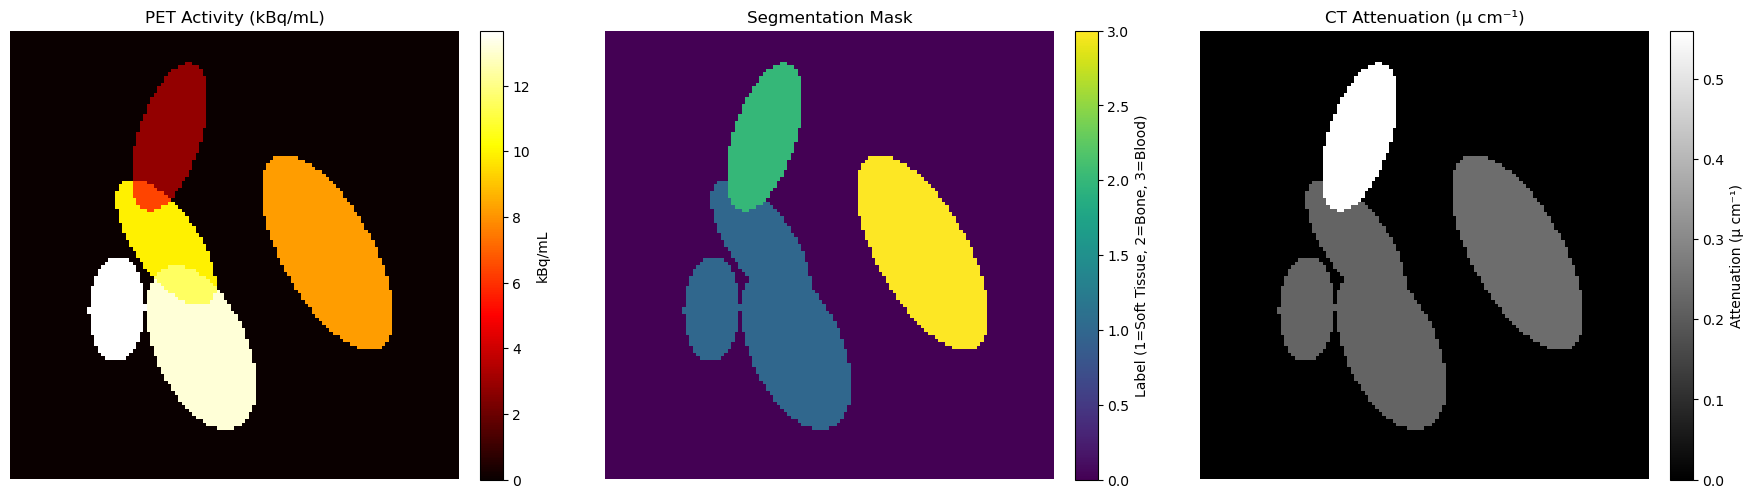

In [ ]:
image_size = (128, 128)

def draw_ellipse(image, mask, center, axes, intensity, label, angle):
    yy, xx = np.indices(image.shape)
    cy, cx = center
    ry, rx = axes  

    theta = np.radians(angle)

    # Rotate coordinates around ellipse center
    x_rot = (xx - cx) * np.cos(theta) + (yy - cy) * np.sin(theta)
    y_rot = -(xx - cx) * np.sin(theta) + (yy - cy) * np.cos(theta)

    # Ellipse equation
    ellipse_region = (x_rot**2 / rx**2 + y_rot**2 / ry**2) <= 1

    # Blend overlapping intensities by averaging
    existing_mask = image > 0
    image[ellipse_region] = (image[ellipse_region] + intensity) / (existing_mask[ellipse_region] + 1)

    # Assign segmentation labels
    mask[ellipse_region] = label  # Soft tissue = 1, bone = 2, blood = 3

def generate_pet_image(shape=image_size, num_ellipses=5):  
    img = torch.zeros(shape, dtype=torch.float32)
    mask = torch.zeros(shape, dtype=torch.float32)  # Segmentation mask
    height, width = shape

    soft_tissue_range = (7.9, 15.8)
    bone_range = (2.6, 7.9)
    blood_range = (7.9, 10.5)

    soft_tissue_ratio = 0.6  
    blood_ratio = 0.2  
    bone_ratio = 0.2  

    num_soft_tissue = int(num_ellipses * soft_tissue_ratio)
    num_blood = int(num_ellipses * blood_ratio)
    num_bone = num_ellipses - num_soft_tissue - num_blood  # Ensure sum is total ellipses

    ellipses = []  

    for i in range(num_ellipses):
        valid_position = False
        attempts = 0

        while not valid_position and attempts < 50:
            center = (random.randint(30, width - 30), random.randint(30, height - 30))

            axis_ratio = random.uniform(1.2, 2.5)  
            major_axis = random.randint(15, 35)
            minor_axis = int(major_axis / axis_ratio)

            axes = (major_axis, minor_axis)
            angle = random.uniform(0, 180)  

            if i < num_soft_tissue:
                intensity = random.uniform(*soft_tissue_range)  
                label = 1  
            elif i < num_soft_tissue + num_blood:
                intensity = random.uniform(*blood_range)  
                label = 3  
            else:
                intensity = random.uniform(*bone_range)  
                label = 2  

            valid_position = all(
                np.linalg.norm(np.array(center) - np.array(e[0])) > (0.6 * (axes[0] + e[1][0]))
                for e in ellipses
            )

            if valid_position:
                ellipses.append((center, axes, intensity, label, angle))

            attempts += 1

    for center, axes, intensity, label, angle in ellipses:
        draw_ellipse(img, mask, center, axes, intensity, label, angle)

    return img, mask

def generate_ct_image(segmentation_mask):
    air_mu = 0
    soft_tissue_mu = 0.22
    bone_mu = 0.56
    blood_mu = 0.24  

    ct_image = torch.full_like(segmentation_mask, air_mu, dtype=torch.float32)

    ct_image[segmentation_mask == 1] = soft_tissue_mu  
    ct_image[segmentation_mask == 2] = bone_mu        
    ct_image[segmentation_mask == 3] = blood_mu  

    return ct_image

import matplotlib.pyplot as plt

# Generate PET and segmentation mask
pet_image, segmentation_mask = generate_pet_image()

# Generate CT image from segmentation mask
ct_image = generate_ct_image(segmentation_mask)

# Convert tensors to NumPy for plotting
pet_np = pet_image.cpu().numpy()
seg_np = segmentation_mask.cpu().numpy()
ct_np = ct_image.cpu().numpy()

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PET Image
im1 = axes[0].imshow(pet_np, cmap="hot", origin="lower")
axes[0].set_title("PET Activity (kBq/mL)")
axes[0].axis("off")
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label("kBq/mL")

# Segmentation Mask
im2 = axes[1].imshow(seg_np, cmap="viridis", origin="lower")
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label("Label (1=Soft Tissue, 2=Bone, 3=Blood)")

# CT Image
im3 = axes[2].imshow(ct_np, cmap="gray", origin="lower")
axes[2].set_title("CT Attenuation (μ cm⁻¹)")
axes[2].axis("off")
cbar3 = plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
cbar3.set_label("Attenuation (μ cm⁻¹)")

plt.tight_layout()
plt.show()




<function matplotlib.pyplot.show(close=None, block=None)>

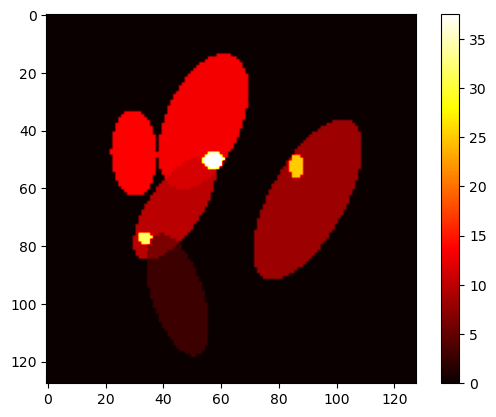

In [7]:
def add_tumors(pet_image, pet_segmentation, num_tumors=3):
    """
    Adds tumors to the PET image, ensuring they are placed inside anatomical structures
    (soft tissue or bone) and have the highest intensity.
    """

    pet_with_tumors = pet_image.clone().detach().to(dtype=torch.float32)
    pet_segmentation = pet_segmentation.clone().detach().to(dtype=torch.int32)


    shape = pet_with_tumors.shape
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1, 1, shape[0]),
        torch.linspace(-1, 1, shape[1]),
        indexing="ij"
    )

    anatomy_mask = (pet_segmentation > 0)  # Only soft tissue (1) & bone (2)

    for _ in range(num_tumors):
        valid_x, valid_y = torch.where(anatomy_mask)  
        if valid_x.numel() == 0: 
            continue  

        # Randomly pick a tumor center inside valid anatomy
        idx = np.random.randint(0, valid_x.numel())
        center = torch.tensor([
            (valid_x[idx].item() / shape[0]) * 2 - 1, 
            (valid_y[idx].item() / shape[1]) * 2 - 1
        ])

        # Tumor size varies but stays within bounds
        radii = torch.tensor([
            np.random.uniform(0.03, 0.07),  
            np.random.uniform(0.03, 0.07)
        ])
        
        # Define tumor mask using an ellipse equation
        tumor = (((grid_x - center[0]) / radii[0]) ** 2 + ((grid_y - center[1]) / radii[1]) ** 2) <= 1
        tumor = tumor & anatomy_mask  # Ensure tumor stays inside valid areas

        if tumor.sum() == 0:  
            continue

        # Assign realistic tumor activity based on soft tissue/bone activity
        surrounding_activity = pet_with_tumors[tumor].mean().item()
        tumor_intensity = surrounding_activity * np.random.uniform(2.0, 3.5)  # Tumors are 2x-3.5x more active  
        pet_with_tumors[tumor] = tumor_intensity  

        # Mark tumor in segmentation mask (e.g., label 99)
        pet_segmentation[tumor] = 99  

    # Convert back to NumPy
    return pet_with_tumors.numpy()

pet_with_tumors = add_tumors(pet_image,segmentation_mask,num_tumors=3)

plt.imshow(pet_with_tumors,cmap="hot")
plt.colorbar()
plt.show

In [58]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter

# Function to add contamination (simulating scatter & random background events)
def add_contamination(image, contamination_factor=0.1):
    if isinstance(image, np.ndarray):  
        image = torch.tensor(image, dtype=torch.float32)

    contamination = contamination_factor * torch.mean(image) * torch.ones_like(image)
    return image + contamination


# Function to apply Gaussian blurring (simulating scanner resolution)
def apply_blurring(image, sigma=None):
    image_np = image.cpu().numpy()
    
    # Adaptive sigma: Make it dependent on image size if not given
    if sigma is None:
        sigma = max(image_np.shape) * 0.02  # Increase for stronger blur
    
    blurred = gaussian_filter(image_np, sigma=sigma, mode="nearest")  
    return torch.tensor(blurred, dtype=torch.float32, device=image.device)


# Function to add Poisson noise to PET image (we increase noise level)
def add_poisson_noise_pet(image, noise_scale):
    image_np = image.cpu().numpy()
    
    # Ensure non-negative values
    image_np = np.clip(image_np, 0, None)  
    
    # Manually increase noise by multiplying intensity before Poisson sampling
    noisy_image = np.random.poisson(image_np * noise_scale).astype(np.float32) / noise_scale
    
    return torch.tensor(noisy_image, dtype=torch.float32, device=image.device)


# Function to add Poisson noise to CT image (we decrease noise level)
def add_poisson_noise_ct(image, noise_scale):
    image_np = image.cpu().numpy()
    
    # Ensure non-negative values
    image_np = np.clip(image_np, 0, None)  
    
    # Reduce CT noise by scaling down before applying Poisson noise
    noisy_image = np.random.poisson(image_np * noise_scale).astype(np.float32) / noise_scale
    
    return torch.tensor(noisy_image, dtype=torch.float32, device=image.device)


In [ ]:
# Dataset 
class PETCTDataset(Dataset):
    def __init__(self, num_samples, image_size):
        self.num_samples = num_samples
        self.image_size = image_size
        self.pet_images = []
        self.ct_images = []
        self.pet_sinograms_clean = []  
        self.ct_sinograms_clean = []
        self.pet_sinograms_noisy = []  # Store processed PET projections
        self.ct_sinograms_noisy = []  # Store noisy CT projections

        for _ in range(num_samples):
            
            pet_image, segmentation_mask = generate_pet_image()
            pet_with_tumors = add_tumors(pet_image,segmentation_mask,3)
            
            ct_image = generate_ct_image(segmentation_mask)
            
            pet_sinogram_clean = ray_trafo(pet_with_tumors)
            ct_sinogram_clean = ray_trafo(ct_image)
            pet_sinogram_clean = torch.tensor(np.array(pet_sinogram_clean), dtype=torch.float32)
            ct_sinogram_clean = torch.tensor(np.array(ct_sinogram_clean), dtype=torch.float32)
                        
            pet_sino_contamin = add_contamination(pet_sinogram_clean,contamination_factor=0.1)
            pet_sino_blurry = apply_blurring(pet_sino_contamin,sigma=3.5)
            pet_sino_noisy = add_poisson_noise_pet(pet_sino_blurry, noise_scale=0.07)
            
            ct_sino_noisy = add_poisson_noise_ct(ct_sinogram_clean,noise_scale=10.0)
        
            
            # Store results
            self.pet_images.append(pet_with_tumors)
            self.ct_images.append(ct_image)
            self.pet_sinograms_clean.append(pet_sinogram_clean.clone().detach().to(device))
            self.ct_sinograms_clean.append(ct_sinogram_clean.clone().detach().to(device))
            self.pet_sinograms_noisy.append(pet_sino_noisy.clone().detach().to(device))
            self.ct_sinograms_noisy.append(ct_sino_noisy.clone().detach().to(device))

            
            
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return (
            self.pet_images[idx],              
            self.ct_images[idx],                   
            self.pet_sinograms_clean[idx],   
            self.ct_sinograms_clean[idx],  
            self.pet_sinograms_noisy[idx],       
            self.ct_sinograms_noisy[idx],        
            
        )

#Create Dataset and DataLoader
set_random_seed(1)
dataset = PETCTDataset(num_samples=1,image_size=image_size) # Set the sample size 
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)



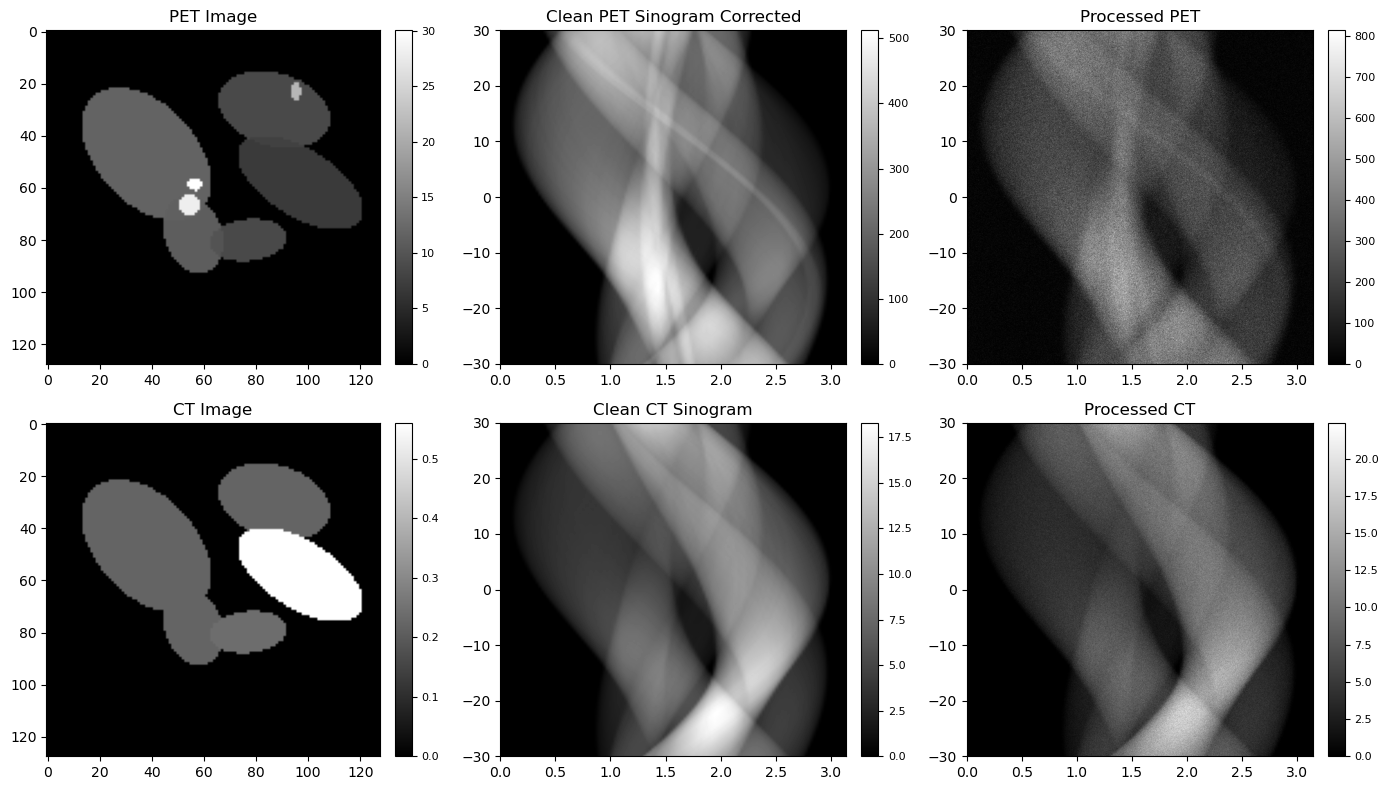

In [ ]:
# Visualize first sample 
pet_images, ct_images, pet_sinograms_clean, ct_sinograms_clean, pet_sinograms_noisy, ct_sinograms_noisy = dataset[0]

fig, ax = plt.subplots(2, 3, figsize=(14, 8))

# Function to add colorbar with fixed limits
def add_colorbar(im, ax):
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  


im0 = ax[0, 0].imshow(pet_images, cmap="gray")
ax[0, 0].set_title("PET Image")
add_colorbar(im0, ax[0, 0])

im1 = ax[0, 1].imshow(pet_sinograms_clean, cmap="gray",aspect="auto", extent=[0, np.pi, -30, 30])
ax[0, 1].set_title("Clean PET Sinogram Corrected")
add_colorbar(im1, ax[0, 1])

im2 = ax[0, 2].imshow(pet_sinograms_noisy, cmap="gray",aspect="auto", extent=[0, np.pi, -30, 30])
ax[0, 2].set_title("Processed PET")
add_colorbar(im2, ax[0, 2])

im3 = ax[1, 0].imshow(ct_images, cmap="gray")
ax[1, 0].set_title("CT Image")
add_colorbar(im3, ax[1, 0])

im4 = ax[1, 1].imshow(ct_sinograms_clean, cmap="gray",aspect="auto", extent=[0, np.pi, -30, 30])
ax[1, 1].set_title("Clean CT Sinogram")
add_colorbar(im4, ax[1, 1])

im5 = ax[1, 2].imshow(ct_sinograms_noisy, cmap="gray",aspect="auto", extent=[0, np.pi, -30, 30])
ax[1, 2].set_title("Processed CT")
add_colorbar(im5, ax[1, 2])

plt.tight_layout()
plt.show()

In [ ]:
pet_images_cpu = [x.cpu() for x in dataset.pet_images]
ct_images_cpu = [x.cpu() for x in dataset.ct_images]
pet_sinograms_clean_cpu = [x.cpu() for x in dataset.pet_sinograms_clean]
ct_sinograms_clean_cpu = [x.cpu() for x in dataset.ct_sinograms_clean]
pet_sinograms_noised_cpu = [x.cpu() for x in dataset.pet_sinograms_noisy]
ct_sinograms_noised_cpu = [x.cpu() for x in dataset.ct_sinograms_noisy]

# dictionary
save_dict = {
    'pet_images_clean': pet_images_cpu,
    'ct_images_clean': ct_images_cpu,
    'pet_sinograms_clean': pet_sinograms_clean_cpu,
    'ct_sinograms_clean': ct_sinograms_clean_cpu,
    'pet_sinograms_noised': pet_sinograms_noised_cpu,
    'ct_sinograms_noised': ct_sinograms_noised_cpu,
}

# save
save_path = 'pet_ct_dataset_odl.pt'
torch.save(save_dict, save_path)
print(f"data has been saved to：{save_path}")